In [2]:
#Import Libraries/Packages
import numpy as np
import cv2
import os
import random
from skimage.io import imread
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D,MaxPooling2D,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from IPython.display import Audio

In [3]:
train_dir = r'/Users/shaikayesha/Downloads/archive (1)/train'
test_dir = r'/Users/shaikayesha/Downloads/archive (1)/test'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path +"/" +expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       happy   sad  fear  surprise  neutral  angry  disgust
train   7215  4830  4097      3171     4965   3995      436
      happy   sad  fear  surprise  neutral  angry  disgust
test   1774  1247  1024       831     1233    958      111


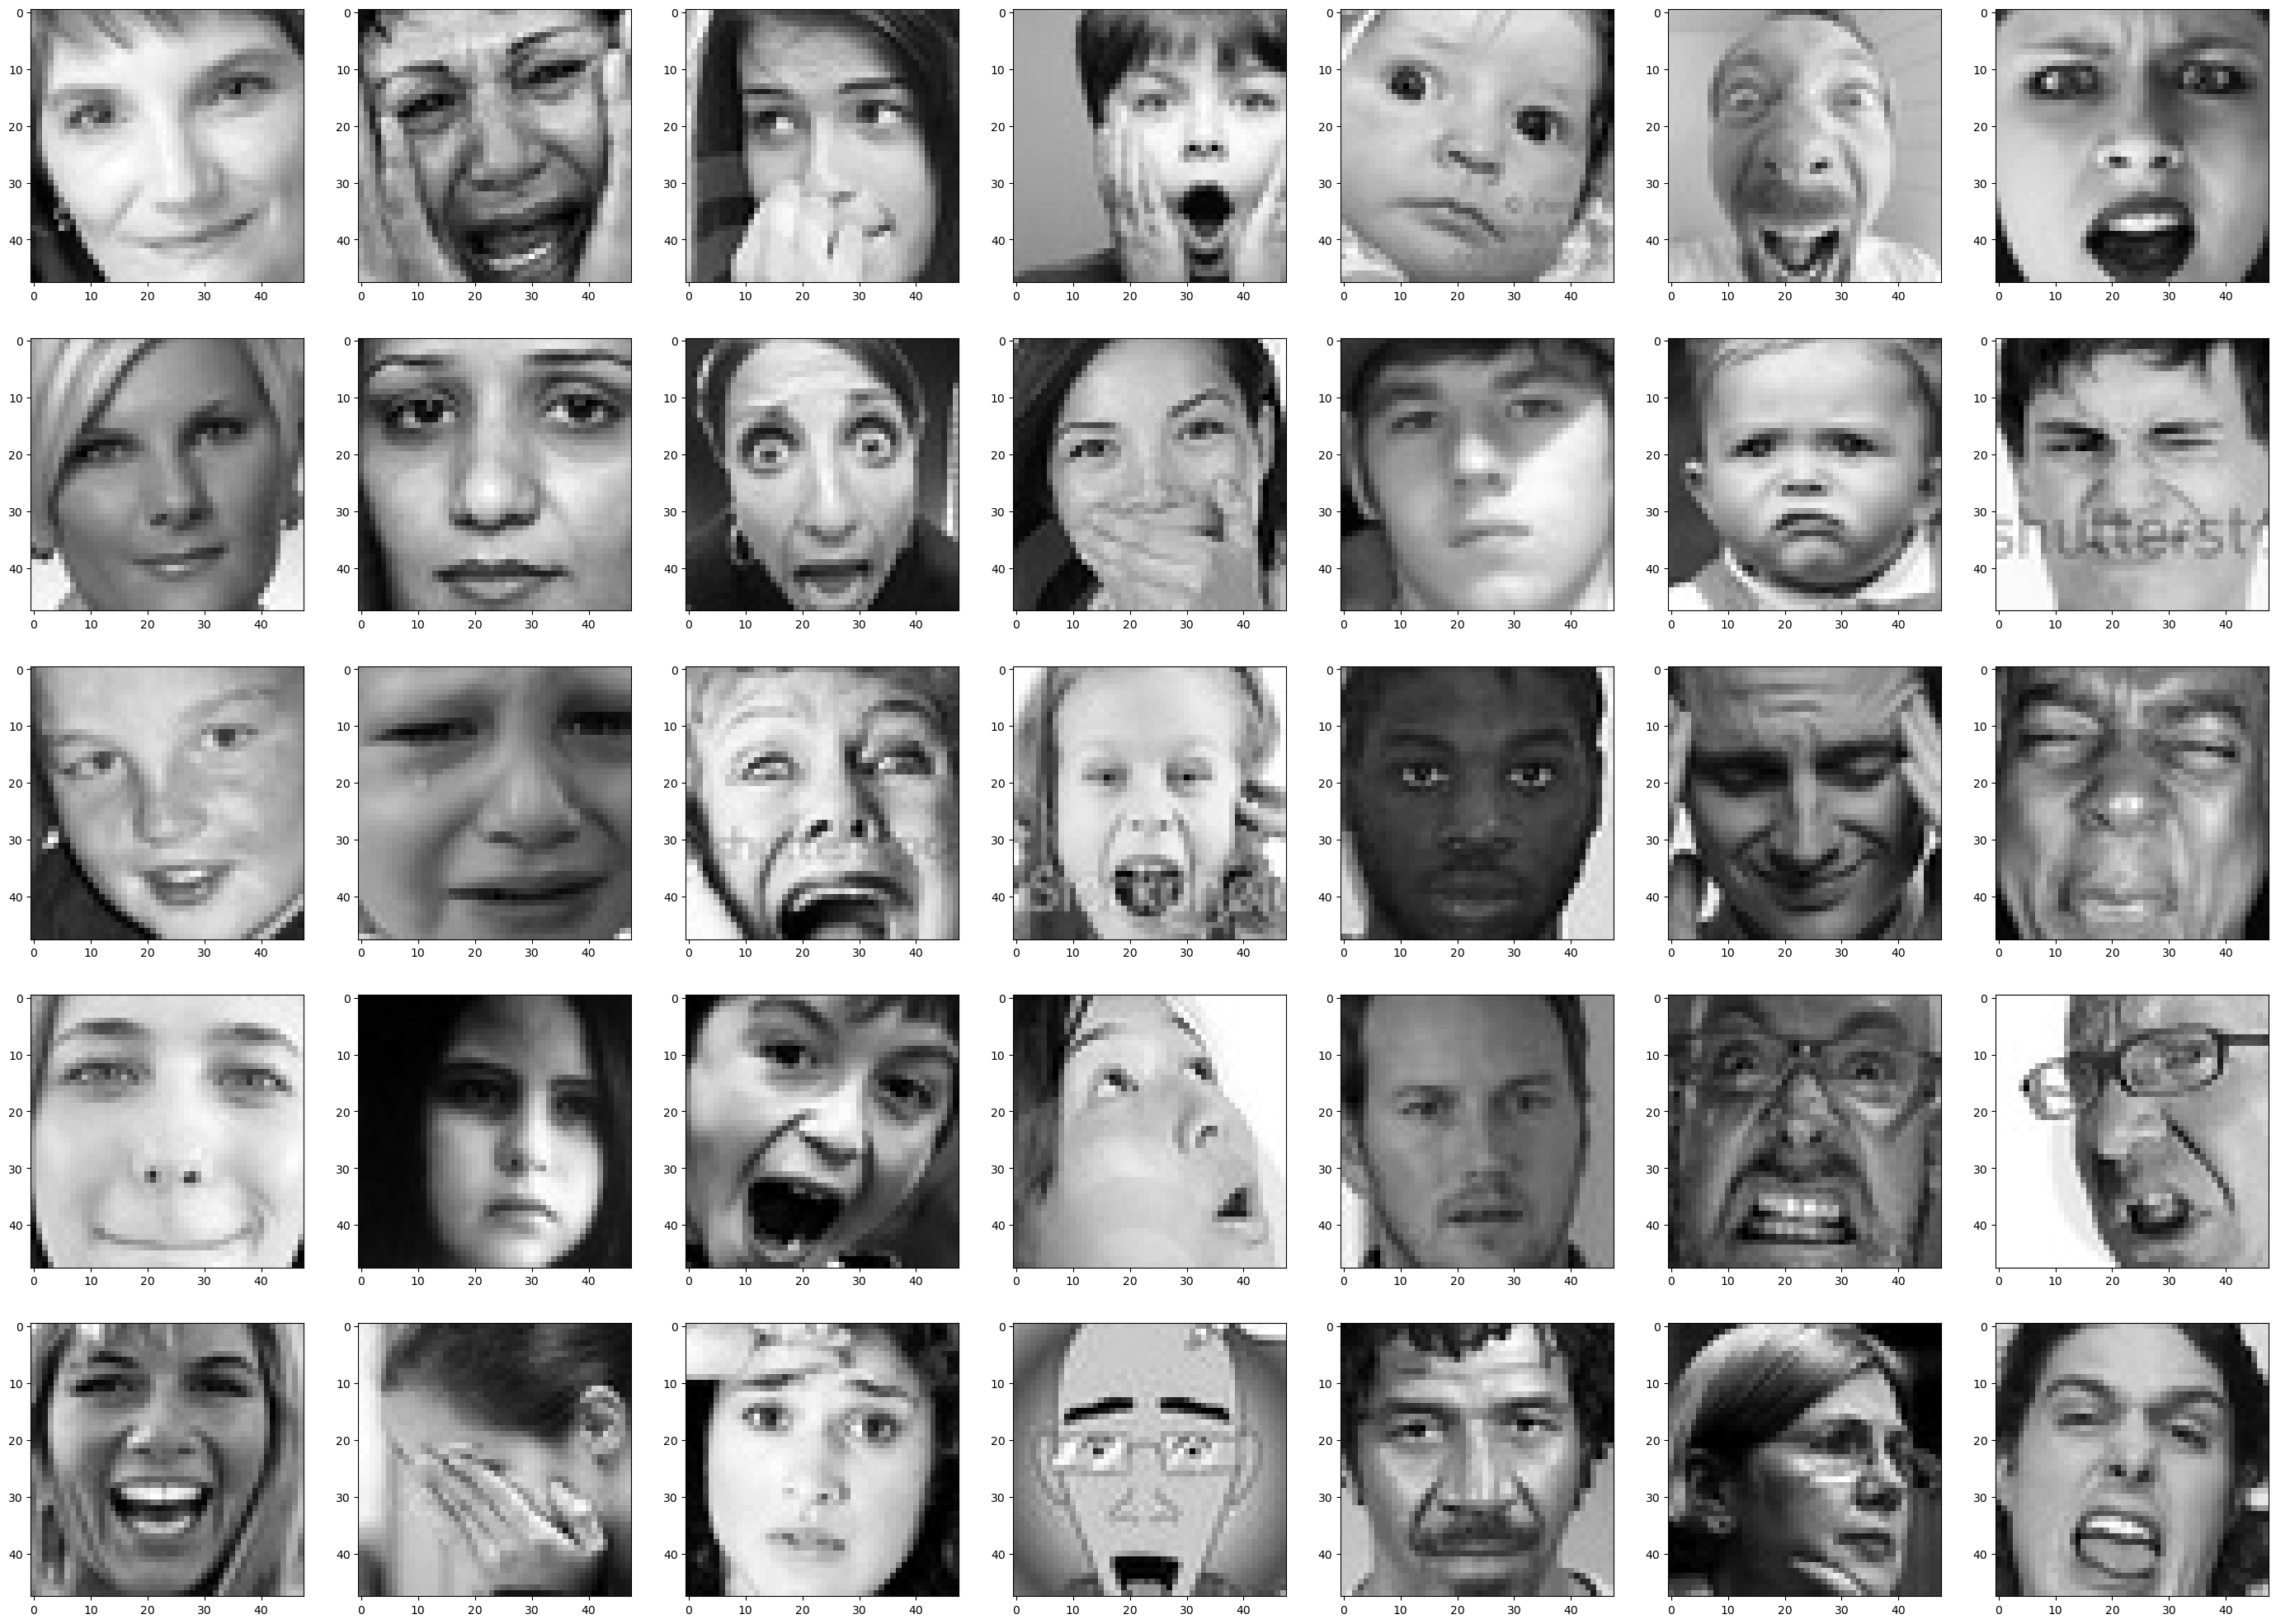

In [8]:
import os
import matplotlib.pyplot as plt
from skimage.io import imread

train_dir = '/Users/shaikayesha/Downloads/archive (1)/train'
test_dir = '/Users/shaikayesha/Downloads/archive (1)/test'
total_labels = len(os.listdir(train_dir))

fig, ax = plt.subplots(nrows=5, ncols=total_labels, figsize=(35, 25))
for x in range(5):
    for y, v in enumerate(os.listdir(train_dir)):
        ax[x][y].imshow(imread(os.path.join(train_dir, v, os.listdir(os.path.join(train_dir, v))[x])), cmap='gray')

plt.show()


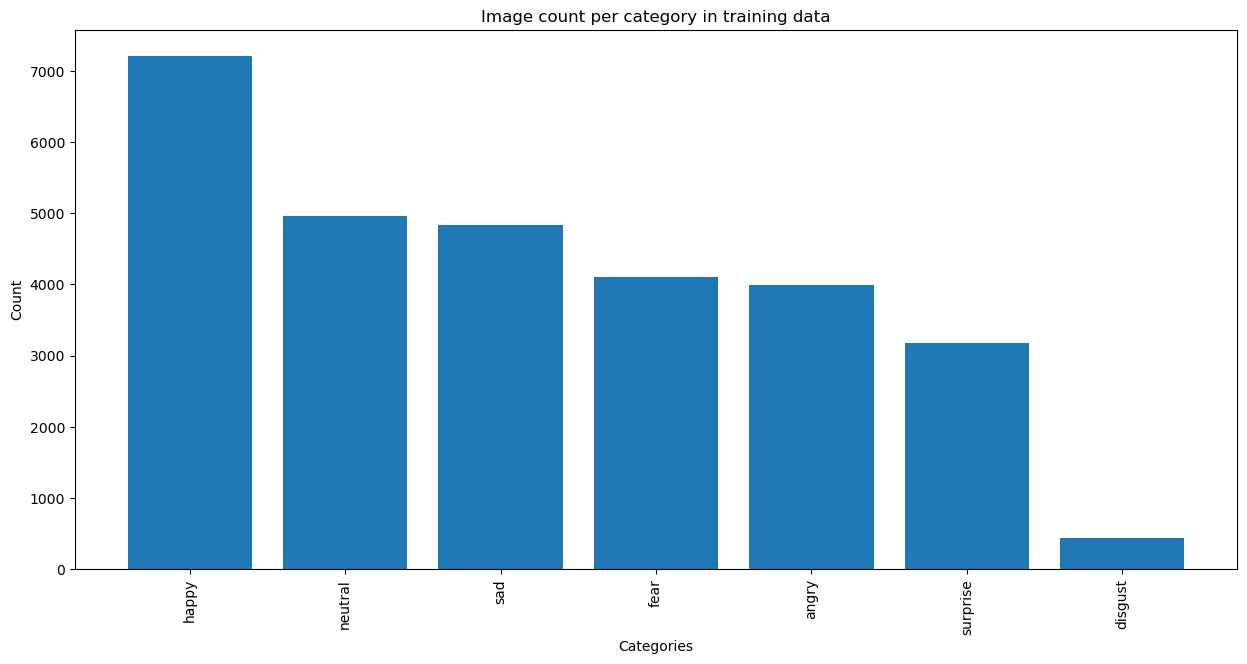

In [10]:
import os
import matplotlib.pyplot as plt
import pandas as pd

train_dir = '/Users/shaikayesha/Downloads/archive (1)/train/'
test_dir = '/Users/shaikayesha/Downloads/archive (1)/test/'
df = {}

for i in os.listdir(train_dir):
    directory = os.path.join(train_dir, i)
    df[i] = len(os.listdir(directory))

df = pd.DataFrame(df, index=["total"]).transpose().sort_values("total", ascending=False)

plt.figure(figsize=(15,7))
plt.bar(df.index, df["total"])
plt.xticks(rotation=90)
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Image count per category in training data')
plt.show()


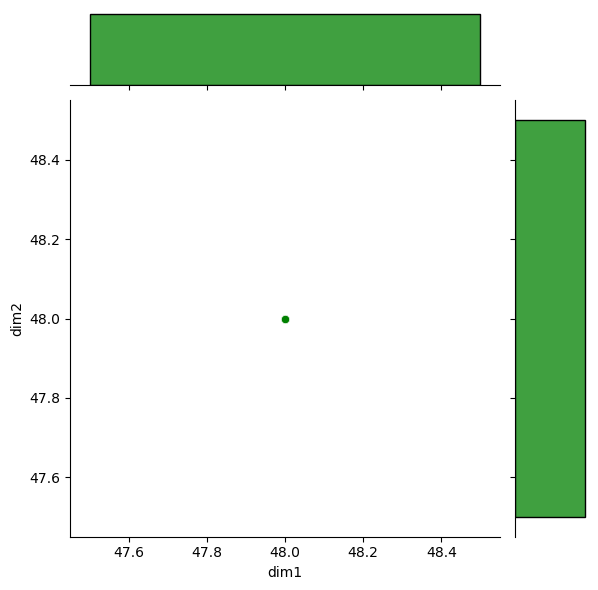

In [11]:
happy = os.listdir(train_dir+'happy/')
dim1, dim2 = [], []

for img_filename in happy:
    img = imread(train_dir+'happy/'+img_filename)
    d1, d2 = img.shape
    dim1.append(d1)
    dim2.append(d2)

df = pd.DataFrame({'dim1': dim1, 'dim2': dim2})
sns.jointplot(data=df, x='dim1', y='dim2', color='g')
plt.show()

In [12]:
# Data Preprocessing
train_gen = ImageDataGenerator(rescale=1/255,
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest')

test_gen = ImageDataGenerator(rescale=1/255)

img_shape = (int(np.mean(dim1)), int(np.mean(dim2)), 1)

train_generator = train_gen.flow_from_directory(directory=train_dir,
                                                target_size=(img_shape[0], img_shape[1]),
                                                color_mode='grayscale',
                                                batch_size=64,
                                                class_mode='categorical',
                                                shuffle=True)

test_generator = test_gen.flow_from_directory(directory=test_dir,
                                                target_size=(img_shape[0], img_shape[1]),
                                                color_mode='grayscale',
                                                batch_size=64,
                                                class_mode='categorical',
                                                shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [13]:
# Create the Model
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', input_shape=img_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=len(os.listdir(train_dir)), activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 24, 24, 128)       5

In [16]:
from keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


In [17]:
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = test_generator.n // test_generator.batch_size
num_epochs = 20

history = model.fit(train_generator,
                    epochs=num_epochs,
                    verbose=1,
                    #callbacks=callbacks,
                    validation_data=test_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)

Epoch 1/20
448/448 [==============================] - 236s 525ms/step - loss: 1.8794 - accuracy: 0.2299 - val_loss: 2.0548 - val_accuracy: 0.2306
Epoch 2/20
448/448 [==============================] - 232s 518ms/step - loss: 1.7991 - accuracy: 0.2469 - val_loss: 1.7668 - val_accuracy: 0.2641
Epoch 3/20
448/448 [==============================] - 289s 644ms/step - loss: 1.7863 - accuracy: 0.2549 - val_loss: 1.7744 - val_accuracy: 0.2690
Epoch 4/20
448/448 [==============================] - 503s 1s/step - loss: 1.7708 - accuracy: 0.2662 - val_loss: 1.7669 - val_accuracy: 0.2928
Epoch 5/20
448/448 [==============================] - 233s 519ms/step - loss: 1.7571 - accuracy: 0.2807 - val_loss: 1.6762 - val_accuracy: 0.3318
Epoch 6/20
448/448 [==============================] - 1725s 4s/step - loss: 1.7322 - accuracy: 0.2934 - val_loss: 1.6694 - val_accuracy: 0.3432
Epoch 7/20
448/448 [==============================] - 225s 503ms/step - loss: 1.7117 - accuracy: 0.3081 - val_loss: 1.6123 - val_

In [18]:
model.save("model.h5")

/Users/shaikayesha/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print("validation accuracy :", str(test_acc*100)+"%")
print("validation loss :", test_loss)

113/113 [==============================] - 13s 112ms/step - loss: 1.2165 - accuracy: 0.5378
validation accuracy : 53.775423765182495%
validation loss : 1.216469168663025


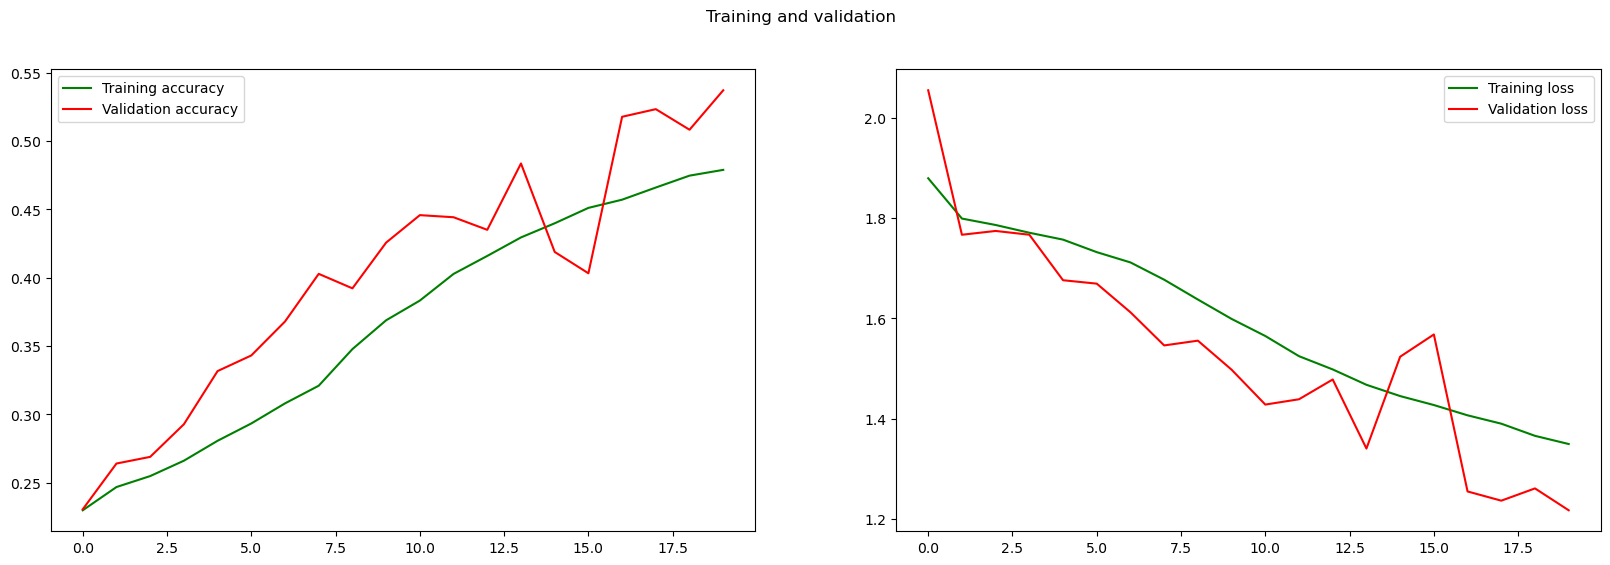

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax[0].plot(epochs, acc, 'g', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
ax[0].legend(loc=0)
ax[1].plot(epochs, loss, 'g', label='Training loss')
ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
ax[1].legend(loc=0)

plt.suptitle('Training and validation')
plt.show()


113/113 [==============================] - 13s 112ms/step
              precision    recall  f1-score   support

       angry       0.37      0.56      0.44       958
     disgust       0.00      0.00      0.00       111
        fear       0.35      0.18      0.24      1024
       happy       0.80      0.80      0.80      1774
     neutral       0.52      0.49      0.51      1233
         sad       0.44      0.35      0.39      1247
    surprise       0.54      0.81      0.65       831

    accuracy                           0.54      7178
   macro avg       0.43      0.46      0.43      7178
weighted avg       0.53      0.54      0.52      7178





/Users/shaikayesha/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shaikayesha/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shaikayesha/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


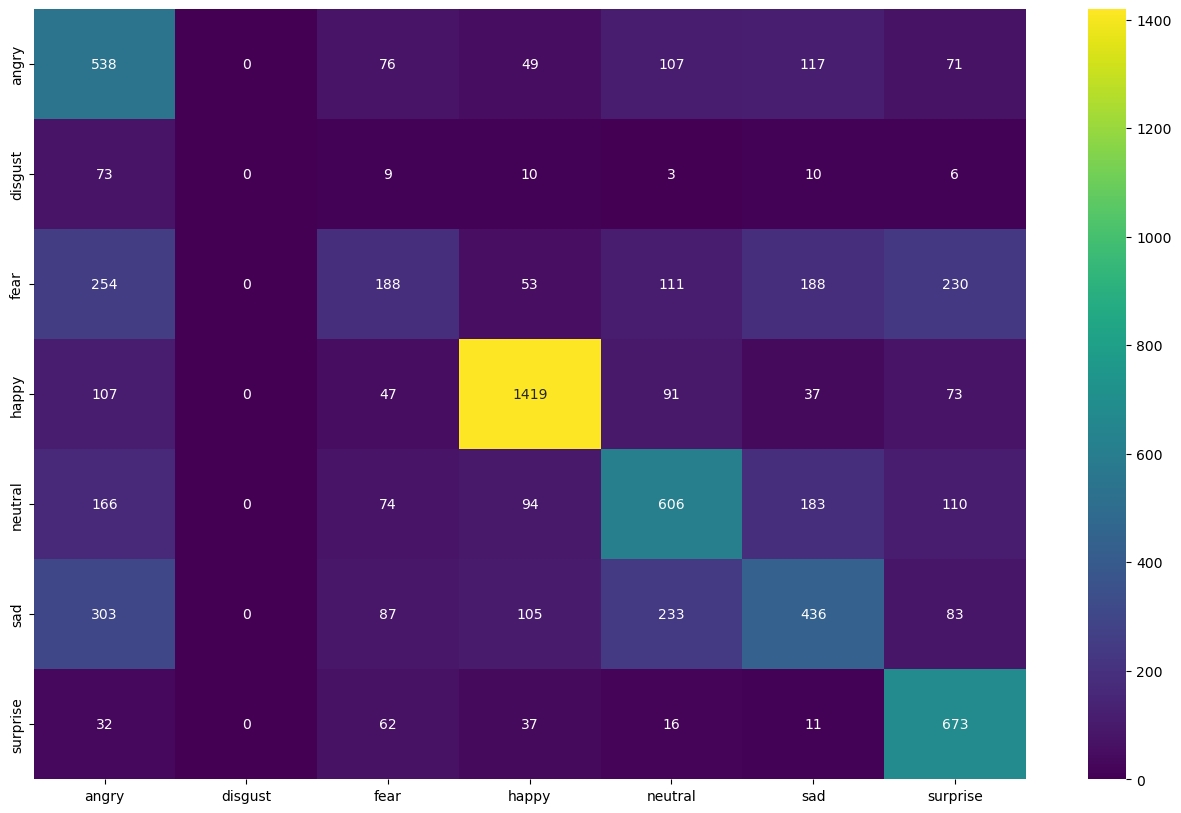

In [21]:
# confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(model.predict(test_generator), axis=-1)
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()), end='\n\n\n')

cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(16,10))
sns.heatmap(cm, cmap=plt.cm.viridis, annot=True, fmt='.0f', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.show()


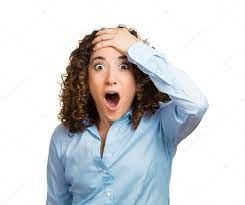

In [23]:
# Testing our model with new image
image = cv2.imread("/Users/shaikayesha/Downloads/surprise.jpg")
from IPython.display import Image
Image(filename='/Users/shaikayesha/Downloads/surprise.jpg')

In [24]:
import cv2
from tensorflow.python.keras.models import load_model
import os

# Load the trained model
model = tf.keras.models.load_model("model.h5",
                                   custom_objects={'Functional': tf.keras.models.Model})
# A list of emoticon categories
EMOTIONS = ['Angry', 'Disgust', 'Happy', 'Sad', 'Surprise', 'Neutral']
# Load image
img = image

# Trim the image to 48 x 48, convert to grayscale, and normalize
frame = cv2.resize(img, (48, 48), interpolation=cv2.INTER_LINEAR)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) / 255.0

# Reshape the image dimension
gray = gray.reshape(1, 48, 48, 1)

# Output the prediction
predicts = model.predict(gray)[0]
label = EMOTIONS[predicts.argmax()]
for (i, j) in zip(range(7), EMOTIONS):
    predictss = predicts[i]
    print("{:^10s}".format(j) + " prediction rate is   {0:.2f}%".format(predictss))
print("\n\n The system considers this expression to be:", label)

1/1 [==============================] - 0s 52ms/step
  Angry    prediction rate is   0.18%
 Disgust   prediction rate is   0.04%
  Happy    prediction rate is   0.22%
   Sad     prediction rate is   0.15%
 Surprise  prediction rate is   0.13%
 Neutral   prediction rate is   0.16%


 The system considers this expression to be: Happy


Now Playing: Training_63590995.jpg



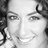

In [28]:
import random
from IPython.display import Audio, display

if label == 'Angry':
    path = "/Users/shaikayesha/Downloads/archive (1)/train/angry"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(filename=os.path.join(path, d), autoplay=True)
    display(audio)

elif label == 'Disgust':
    path = "/Users/shaikayesha/Downloads/archive (1)/train/disgust"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(filename=os.path.join(path, d), autoplay=True)
    display(audio)

elif label == "Happy":
    path = "/Users/shaikayesha/Downloads/archive (1)/train/happy"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(filename=os.path.join(path, d), autoplay=True)
    display(audio)

elif label == 'Sad':
    path = "/Users/shaikayesha/Downloads/archive (1)/train/sad"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(filename=os.path.join(path, d), autoplay=True)
    display(audio)

elif label == 'Surprise':
    path = "/Users/shaikayesha/Downloads/archive (1)/train/surprise"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(filename=os.path.join(path, d), autoplay=True)
    display(audio)

elif label == 'Neutral':
    path = "/Users/shaikayesha/Downloads/archive (1)/train/neutral"
    files = os.listdir(path)
    d = random.choice(files)
    print("Now Playing:", d)
    audio = Audio(filename=os.path.join(path, d), autoplay=True)
    display(audio)
